In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/binance-full-history/WAVES-USDT.parquet
/kaggle/input/binance-full-history/RLC-BNB.parquet
/kaggle/input/binance-full-history/AE-BTC.parquet
/kaggle/input/binance-full-history/BTC-GBP.parquet
/kaggle/input/binance-full-history/RVN-BNB.parquet
/kaggle/input/binance-full-history/DOTDOWN-USDT.parquet
/kaggle/input/binance-full-history/MATIC-BUSD.parquet
/kaggle/input/binance-full-history/HIVE-BTC.parquet
/kaggle/input/binance-full-history/DOT-BUSD.parquet
/kaggle/input/binance-full-history/XRP-USDC.parquet
/kaggle/input/binance-full-history/KAVA-USDT.parquet
/kaggle/input/binance-full-history/AXS-USDT.parquet
/kaggle/input/binance-full-history/STX-BTC.parquet
/kaggle/input/binance-full-history/XRP-PAX.parquet
/kaggle/input/binance-full-history/SHIB-BUSD.parquet
/kaggle/input/binance-full-history/CTXC-USDT.parquet
/kaggle/input/binance-full-history/TRX-USDT.parquet
/kaggle/input/binance-full-history/ANKR-BTC.parquet
/kaggle/input/binance-full-history/DOT-TRY.parquet
/kaggle/i

In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib as ta

--2022-02-21 19:38:50--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-02-21 19:38:50--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-02-21 19:38:50--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.s

In [3]:
import talib as ta

In [4]:
import pyarrow.parquet as pq

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [6]:
main_df = pd.DataFrame()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pair = filename.split(".")[0].split("-")
        if pair[1] != "USDT":
            continue
        if pair[0] not in ("BTC", "ETH", "DOT", "SOL", "BNB", "AXS", "MANA", "NEO", "ANKR", "ADA", "LINK", "FTM", "QTUM", "DYDX", "AVAX", "MATIC", "SUSHI", "FIL", "OMG", "ATOM", "EOS", "SRM", "1INCH", "ALGO", "SXP"):
            continue
        
        df = pq.read_pandas(f"/kaggle/input/binance-full-history/{filename}").to_pandas()
        df.sort_values("open_time")
        df = df.resample("5min").apply(dict(open="first", high="max", low="min", close="last", quote_asset_volume="sum"))
        df = df.rename(columns = {"quote_asset_volume": "volume"}, inplace = False)
        df = df.dropna()

        position_period = 288
        df["l_sl"] = df["close"]*0.99
        df["l_tp"] = df["close"]*1.02
        df["s_sl"] = df["close"]*1.01
        df["s_tp"] = df["close"]*0.98
        df["hh"] = df["high"].rolling(position_period).max().shift(-position_period)
        df["ll"] = df["low"].rolling(position_period).min().shift(-position_period)
        df["label"] = np.where((df["hh"] >= df["l_tp"]), 1, 0)
        df = df.dropna()
        df = df.drop('l_sl', 1)
        df = df.drop('l_tp', 1)
        df = df.drop('s_sl', 1)
        df = df.drop('s_tp', 1)
        df = df.drop('hh', 1)
        df = df.drop('ll', 1)

        #df["rsi_7"] = np.round(ta.RSI(df["close"], timeperiod=7), 0)
        #df["rsi_14"] = np.round(ta.RSI(df["close"], timeperiod=14), 0)
        df["ema_20"] = ta.EMA(df["close"], timeperiod=20)
        df["ema_50"] = ta.EMA(df["close"], timeperiod=50)
        df["ema_200"] = ta.EMA(df["close"], timeperiod=200)
        df["bb_up"], df["bb_mid"], df["bb_low"] = ta.BBANDS(df["close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df["vol_ema_24"] = ta.EMA(df["volume"], timeperiod=24)
        #df["natr"] = np.round(ta.NATR(df["high"], df["low"], df["close"], timeperiod=14), 0)
        df["macd"], df["macdsignal"], df["macdhist"] = ta.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)
        df["macd"] = np.where(df["macd"]>0, 1, -1)
        df["macdsignal"] = np.where(df["macdsignal"]>0, 1, -1)
        df["macdhist"] = np.where(df["macdhist"]>0, 1, -1)

        df["ema_20"] = np.where(df["close"]>df["ema_20"], 1, -1)
        df["ema_50"] = np.where(df["close"]>df["ema_50"], 1, -1)
        df["ema_200"] = np.where(df["close"]>df["ema_200"], 1, -1)
        df["ema_20_50"] = np.where(df["ema_20"]>df["ema_50"], 1, -1)
        df["ema_20_200"] = np.where(df["ema_20"]>df["ema_200"], 1, -1)
        df["ema_50_200"] = np.where(df["ema_50"]>df["ema_200"], 1, -1)
        df["bb_up"] = np.where(df["close"]>df["bb_up"], 1, -1)
        df["bb_mid"] = np.where(df["close"]>df["bb_mid"], 1, -1)
        df["bb_low"] = np.where(df["close"]>df["bb_low"], 1, -1)
        df["vol_ema_24"] = np.where(df["volume"]>df["vol_ema_24"], 1, -1)
        
        df["candle_size"] = df["high"] - df["low"]
        #df["up_wick_ratio"] = np.round(((df["high"] - np.maximum(df["open"], df["close"])) / df["candle_size"]) * 100, 0)
        #df["low_wick_ratio"] = np.round(((np.minimum(df["open"], df["close"]) - df["low"]) / df["candle_size"]) * 100, 0)
        #df["body_ratio"] = np.round((np.abs(df["open"]-df["close"]) / df["candle_size"]) * 100, 0)

        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        df = df.drop('open', 1)
        df = df.drop('high', 1)
        df = df.drop('low', 1)
        df = df.drop('close', 1)
        df = df.drop('volume', 1)
        df = df.drop('candle_size', 1)
        main_df = pd.concat([main_df, df])
        print(filename)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/opt/conda/lib/pytho

AXS-USDT.parquet
1INCH-USDT.parquet
SOL-USDT.parquet
EOS-USDT.parquet
MANA-USDT.parquet
BTC-USDT.parquet
ETH-USDT.parquet
DOT-USDT.parquet
ATOM-USDT.parquet
QTUM-USDT.parquet
SRM-USDT.parquet
SXP-USDT.parquet
SUSHI-USDT.parquet
MATIC-USDT.parquet
FIL-USDT.parquet
ADA-USDT.parquet
FTM-USDT.parquet
NEO-USDT.parquet
ANKR-USDT.parquet
OMG-USDT.parquet
BNB-USDT.parquet
AVAX-USDT.parquet
LINK-USDT.parquet
ALGO-USDT.parquet


In [7]:
main_df = main_df.dropna()
df_for_training_grouped = main_df.groupby("label")
df_for_training_grouped.groups.values()
frames_of_groups = [x.sample(df_for_training_grouped.size().min()) for y, x in df_for_training_grouped]
main_df = pd.concat(frames_of_groups)
print("HOLDS: ", len(main_df[main_df["label"]==0]))
print("LONGS: ", len(main_df[main_df["label"]==1]))
main_df

HOLDS:  2124497
LONGS:  2124497


,label,ema_20,ema_50,ema_200,bb_up,bb_mid,bb_low,vol_ema_24,macd,macdsignal,macdhist,ema_20_50,ema_20_200,ema_50_200
open_time,,,,,,,,,,,,,,
2021-12-19 07:40:00,0,1,1,1,-1,1,1,1,1,1,1,-1,-1,-1
2020-01-31 04:25:00,0,1,1,1,-1,1,1,1,1,1,1,-1,-1,-1
2018-10-23 03:50:00,0,-1,1,1,-1,-1,1,-1,1,1,-1,-1,-1,-1
2019-02-28 22:25:00,0,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1
2021-11-12 02:10:00,0,1,1,-1,-1,1,1,-1,-1,-1,1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27 19:55:00,1,-1,-1,1,-1,-1,1,1,1,1,-1,-1,-1,-1
2021-12-26 10:50:00,1,1,1,1,-1,1,1,-1,1,1,1,-1,-1,-1
2020-01-13 17:40:00,1,-1,1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1


In [8]:
feature_cols = list(main_df)
feature_cols.remove("label")
X = main_df[feature_cols]
y = main_df["label"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [10]:
dt = DecisionTreeClassifier(max_depth=4)
dt = dt.fit(X_train, y_train)
print("Train finished.")
y_pred = dt.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["HOLD", "LONG"]))

Train finished.
Accuracy: 0.5063979810135569
              precision    recall  f1-score   support

        HOLD       0.50      0.61      0.55    636844
        LONG       0.51      0.41      0.45    637855

    accuracy                           0.51   1274699
   macro avg       0.51      0.51      0.50   1274699
weighted avg       0.51      0.51      0.50   1274699



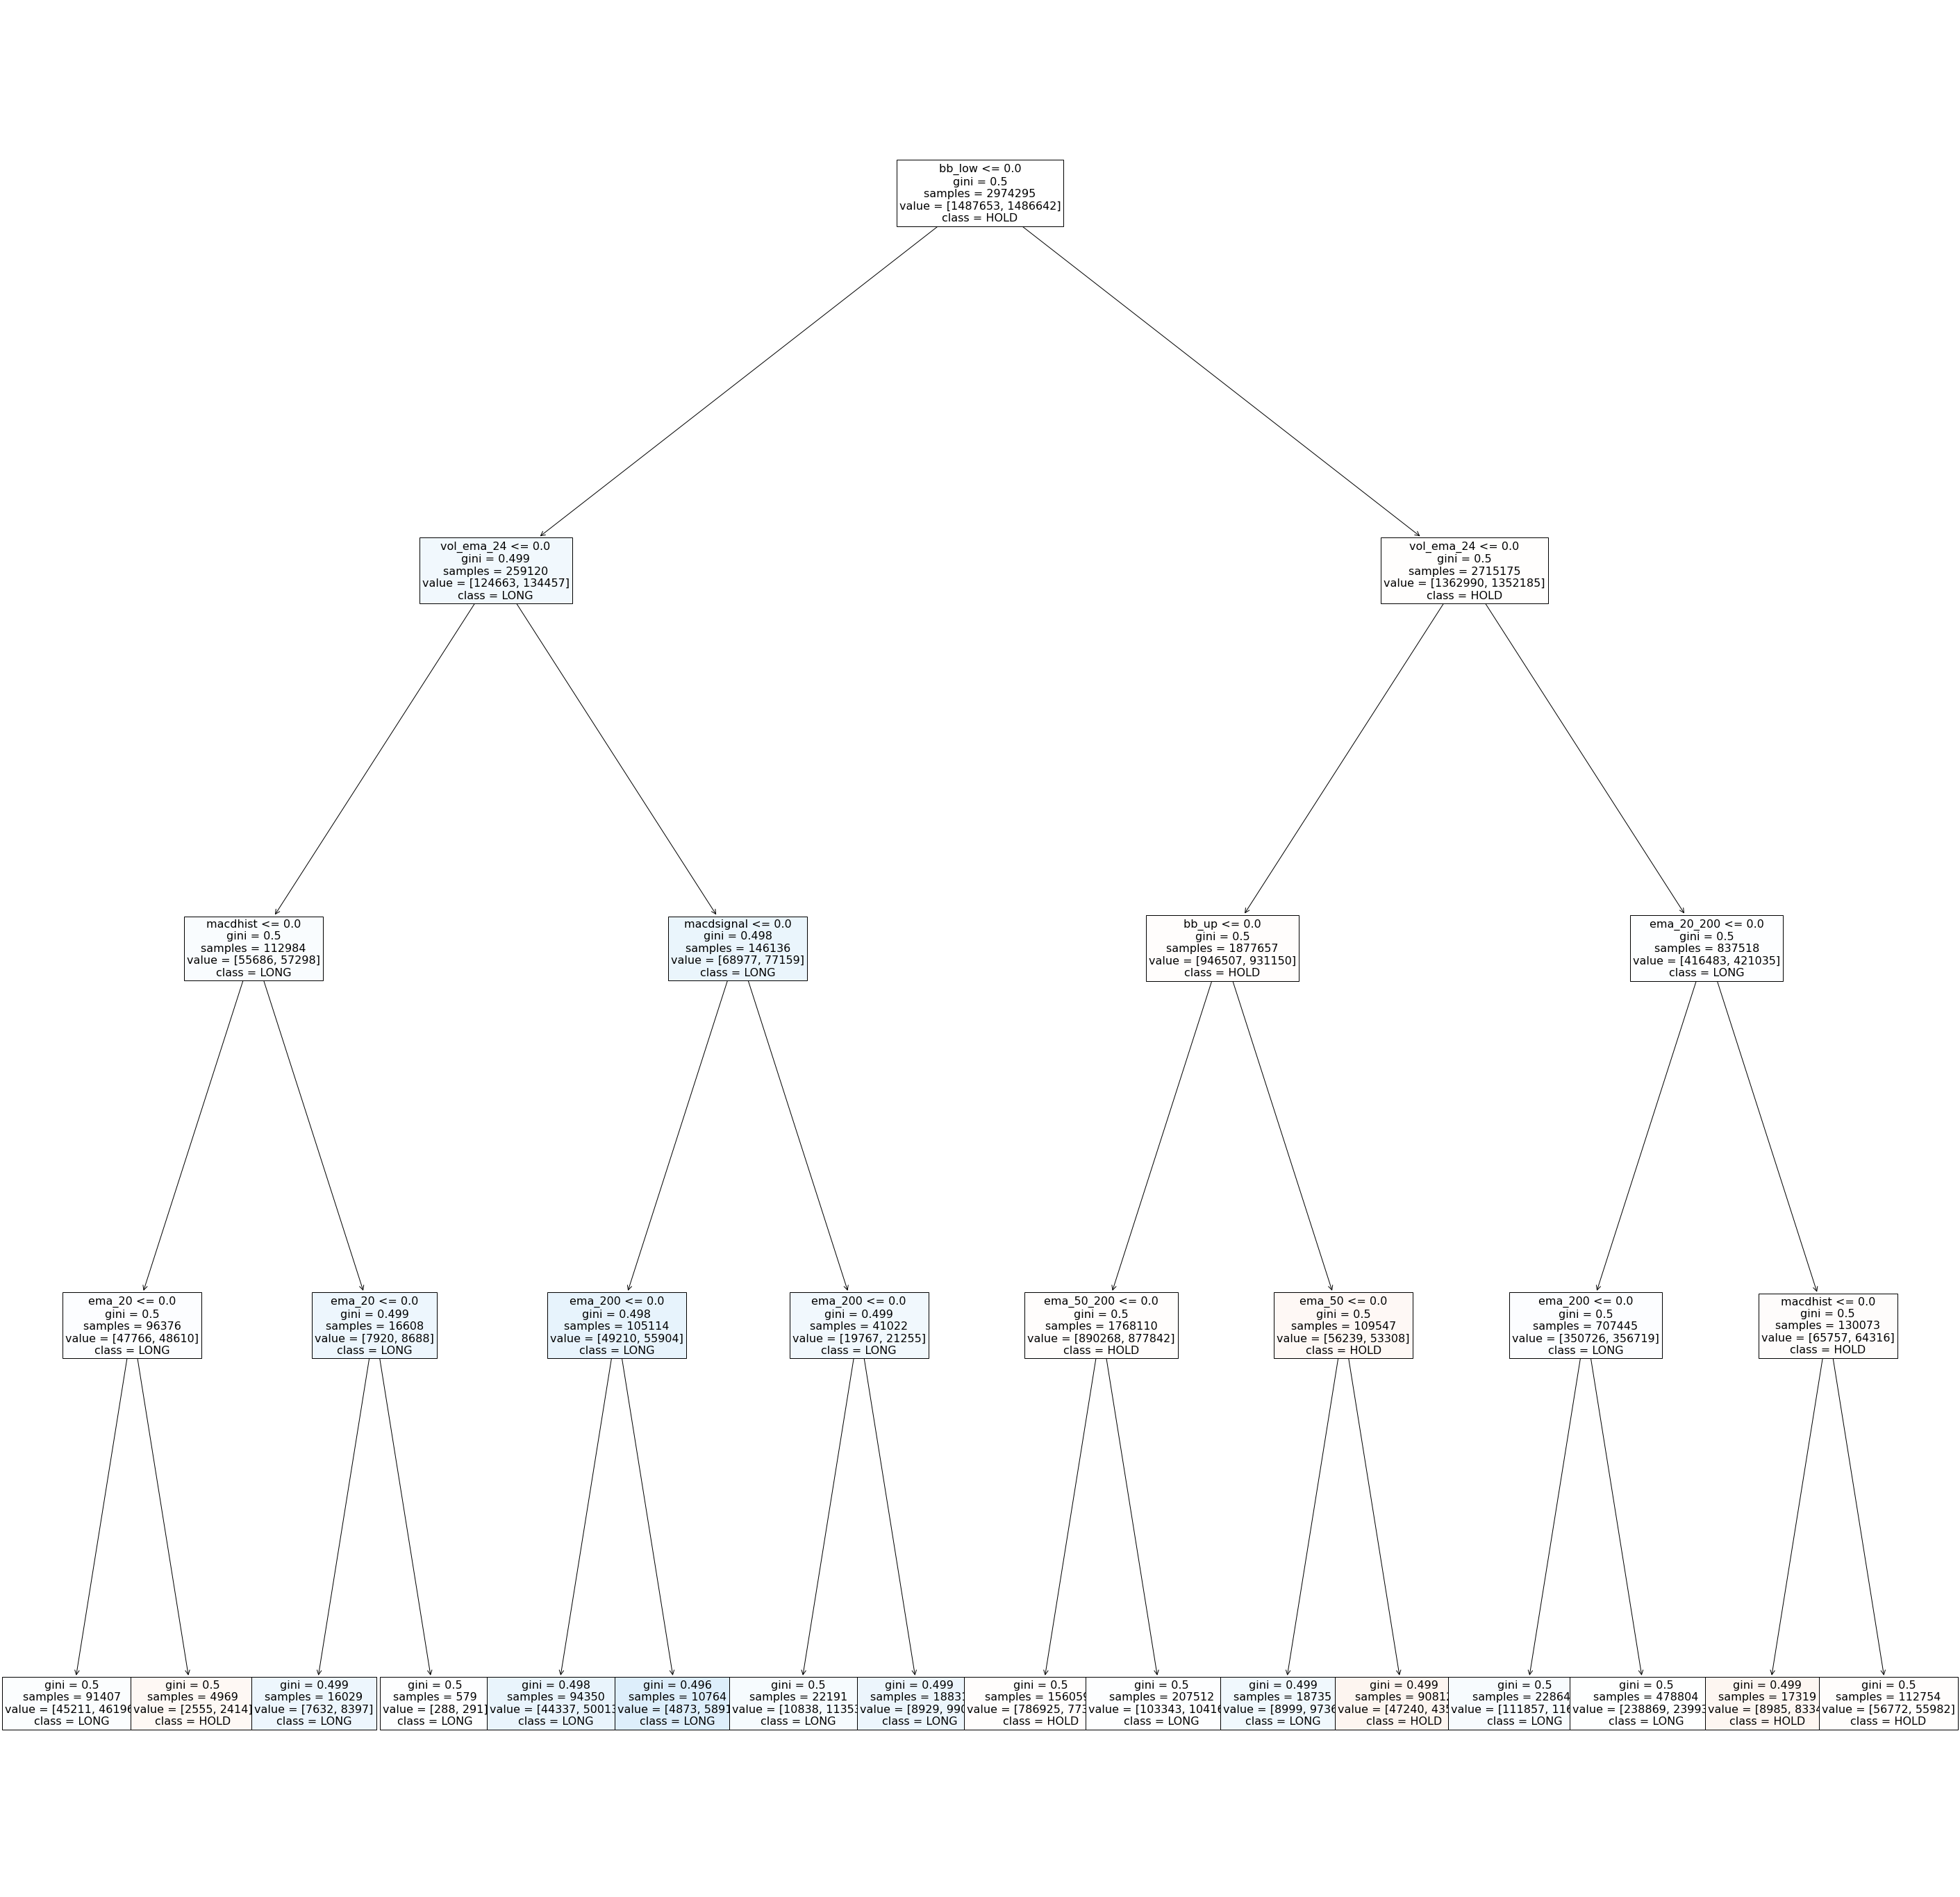

In [11]:
from sklearn import tree
from matplotlib import pyplot as plt
size = 50
plt.figure(figsize=(size, size))
tree.plot_tree(dt, filled=True, fontsize=16, feature_names=feature_cols, class_names=["HOLD", "LONG"])
plt.savefig("dt.pdf")
plt.show()